Convection example
======


This notebook is intended to give a quick overview of how to run underworld using ipython notebooks. It is the beginning of a series of tutorials which will increase in functionality. By the end of these tutorials the user should be able to tackle the more complex notebooks available in the **publications** directory.

**This lesson introduces the concepts of:**
1. Underworld basics.
2. Setting up material parameters and functions.
3. Setting up and solving a Stokes system.
4. Setting up and solving advective diffusive systems.
5. plotting fields.

**Keywords:** material parameters, Stokes system, advective diffusive systems

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer

Setup parameters
-----

Set physical values for test.

In [2]:
# Set number of dimensions.
dim = 2
# Set simulation box size.
boxHeight = 1.0
boxLength = 2.0
# Set min/max temperatures.
tempMin = 0.0
tempMax = 1.0
# Set the resolution.
res = 16

Create mesh and finite element variables
------

Create mesh object. 

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

The mesh object consists of two meshes, the type of which is defined here as ``"Q1/dQ0"``. The primary mesh (``Q1``) has node points on the corners of the cell and is stored in the ``mesh`` object data, while the sub-mesh (``dQ0``) has nodes inside the cell and is accessed via the ``mesh.subMesh`` object. The sub-mesh is used for the pressure field. For more information on meshes see the user guide **02_Meshing**.

Create finite element variables for the velocity, pressure and temperature fields. The last two of these are scalar fields needing only one value at each mesh point, while the velocity field contains a vector of *dim* dimensions at each mesh point.

In [4]:
velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,      nodeDofCount=1 )

Set up material parameters and functions
-----

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. More details on setting functions in underworld is found in the user guide **05_Functions**.

Notes:
1. Temperature must be in the range [0,1] for use with the density function defined using the Rayleigh number.
2. $\hat{z}$ (*z_hat*) denotes the positive vertical direction. 
3. The density ($\rho$) should be negatively proportional to the temperature field so that high temperature has low density.
4. The constant of proportionality in this case is the Rayleigh number, which is set low here to speed up the system.
4. Both $\hat{z}$ and $\rho$ are combined to define the buoyancy function which is used to set up the Stokes system.

In [5]:
# Set viscosity to be a constant.
viscosity = 1.

# Rayleigh number.
Ra = 1.0e4

# Construct our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

By setting the system up in this way we only need to create these functions once at the beginning of the simulation and not each timestep.

Set initial conditions and boundary conditions
----------

**Initial conditions**

First initialise the velocity and pressure fields to zero everywhere in the domain.

In [6]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureDotField.data[:] = 0.

Set a small perturbation in the temperature field to seed the onset of convection.

In [7]:
pertStrength = 0.05
deltaTemp = tempMax - tempMin
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

**Boundary conditions**

This step is to ensure that the temperature boundary conditions are satisfied, as the initial conditions above may have been set to different values on the boundaries.

In [8]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the ``I`` (left and right side walls) and ``J`` (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [9]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

Let's create the boundary conditions.

For (2d) vector variables, we may flag up two Dirichlet conditions on each vertex.. for velocity it's a condition for $v_x$ and one for $v_y$. We provide a tuple of sets specifying which degrees of freedom (Set($v_x$), Set($v_y$)) should be considered Dirichlet.

The temperature is held constant on the top and bottom boundaries via the tempBC object created below.

In [10]:
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

More information on setting boundary conditions is found in the **06_Systems** user guide.

**Plot initial conditions for temperature**



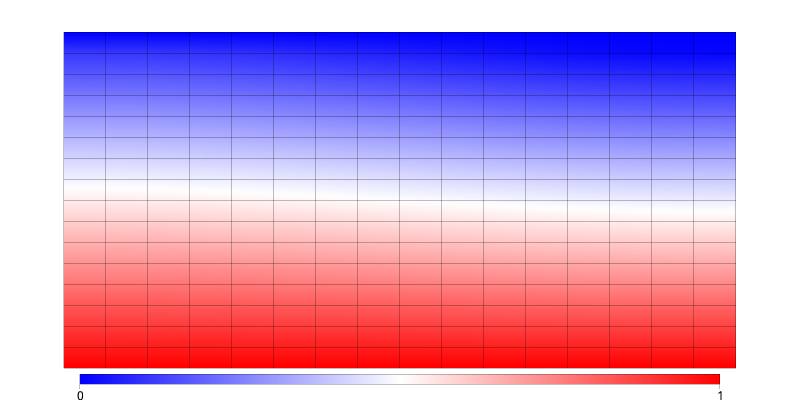

In [11]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.show()

System setup
-----

**Setup a Stokes system**

For most geodynamics problems the motion of the fluid is well described by [incompressible Stokes equations](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations). In underworld setting up such as system requires the velocity field, pressure, viscosity and buoyancy forces be passed to the Stokes system function. Along with the conditions affecting these variables - in this case the boundary conditions for the velocity field.

In [12]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               viscosityFn   = viscosity, 
                               bodyForceFn   = buoyancyFn )

Setup solver using the Stokes system equations

In [13]:
solver = uw.systems.Solver( stokesPIC )

This system is solved after each time step using the .solve function (see main loop below). 

For more information on setting up solvers see the **Systems** user guide.

**Create an advective diffusive system**

For the heat transport in the system the advection diffusion equation is solved for the temperature field. This is used in tandem with the Stokes system, which solves for the velocity field given the temperature and pressure fields (above). More information on the advection diffusion equation can be found [here](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation).

Similar to the Stokes system, the advection diffusion system is setup in underworld by flagging the temperature and velocity field variables as well as the temperature boundary conditions.

In [14]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField, velocityField, 
                                         diffusivity=1., conditions=[tempBC,] )

Main time loop
-----

The main time stepping loop begins here. Before this the time and number of timesteps are initialised to zero. For this particular example the simulation is run for long enough to see convection beginning.


In [15]:
time = 0.
step = 0
steps_end = 10
while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    step += 1

**Plot final temperature field**


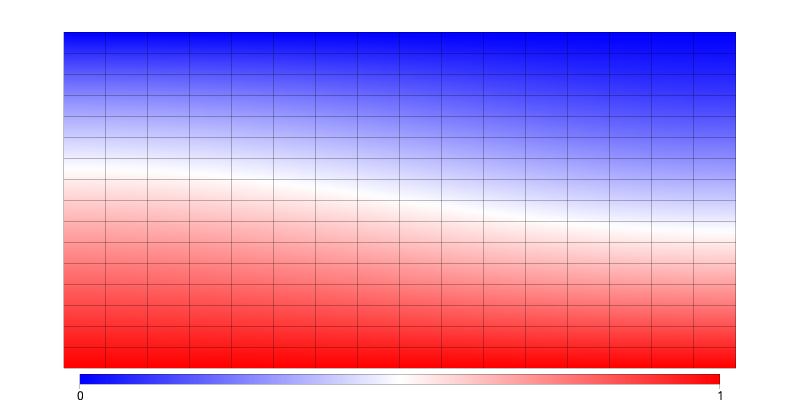

In [16]:
figtemp = glucifer.Figure(figsize=(800,400))
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.show()

**Overlay with velocity field**

To show the convective motion of the fluid we overlay the velocity field over the previous temperature field plot.


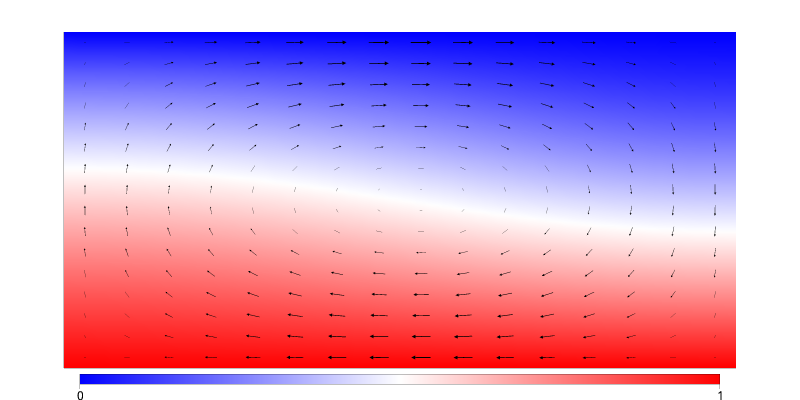

In [17]:
# plot figure
figWithV = glucifer.Figure(figsize=(800,400))
figWithV.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figWithV.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.2) )
figWithV.show()